In [1]:
%matplotlib notebook 
from model.resattnet import SelfPose
from dataloader import XRegoDataset 
from torch.utils.data import DataLoader
import time
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import webdataset as wds
from torchvision import transforms
import glob
from webdataset.handlers import ignore_and_continue
from mpl_toolkits.mplot3d import axes3d 
import typing as tp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
preproc = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),
])

def transform(x):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,3)
    x = np.concatenate((x[6:7], x[2:5], x[14:17], x[22:25], x[5:6], x[29:32], x[35:38]))

    return x.reshape(-1)

def image_preproc(x):
    return preproc(x)



## Plot Kinematic Tree

In [30]:



def get_chain_dots(
        joints: np.ndarray,   # shape == (n_dots, 3)
        chain_dots_indexes: tp.List[int], # length == n_dots_in_chain
                                          # in continuous order, i.e. 
                                          # left_hand_ix >>> chest_ix >>> right_hand_ix
        ) -> np.ndarray:    # chain of dots
    return joints[chain_dots_indexes]


def get_chains(
        joints,   # shape == (n_dots, 3)
        head: tp.List[int], # pelvis >>> chest >>> head
        spine: tp.List[int], # left_leg >>> pelvis >>> right_leg
        arm1: tp.List[int],
        arm2,
        neck,
        right_leg,
        left_leg,
        ):
    return (get_chain_dots(joints, head),
            get_chain_dots(joints, spine),
            get_chain_dots(joints, arm1),
            get_chain_dots(joints, arm2),
            get_chain_dots(joints, neck),
            get_chain_dots(joints, right_leg),
            get_chain_dots(joints, left_leg),
            )


def subplot_nodes(dots: np.ndarray, ax, size=20):
    return ax.scatter3D(*dots.T, c=dots[:, -1], s=size)


def subplot_bones(chains: tp.Tuple[np.ndarray, ...], ax):
    return [ax.plot(*chain.T) for chain in chains]


def plot_skeletons(skeletons, chains_ixs, err_size=20, std_size=20):
    fig = plt.figure(figsize=(10, 5))
    sizes = [err_size, std_size]
    labels = ["Prediction", "Ground Truth"]
    for i, joints in enumerate(skeletons, start=1):
        chains = get_chains(joints, *chains_ixs)
        ax = fig.add_subplot(1, 2, i, projection='3d')
        ax.set_xlabel(labels[i-1], fontsize=10, rotation=100)
        print(len(joints))
        subplot_nodes(joints, ax, sizes[i-1])
        subplot_bones(chains, ax)
    plt.show()
    
def plot(gt_pose, pred_pose, err_size=20, std_size=20):
    # Kinematic Tree for visualization
    # each list create bones between joints
    chains_ixs = ([0],[1, 2, 3],[3, 4, 5, 6],[3, 7, 8, 9],[3, 10],[1, 11,12,13],[1, 14,15,16]) 
    plot_skeletons([gt_pose, pred_pose], chains_ixs, err_size, std_size)
 
       


In [4]:
def load_models():
    paths = ["./ckpts/vae_no_kld/10_epoch_1.6332732890902123e-05.pth"]
#     paths = ["./ckpts/57mm.pth", "./ckpts/model2/5_epoch_0.00025778871799314704.pth",
#              "./ckpts/model3/6_epoch_2.2495238057805626e-05.pth", "./ckpts/model4/5_epoch_0.0002509588166198228.pth",
#              "./ckpts/model5/6_epoch_0.0002385608078126097.pth"]
    models = []
    for path in paths:
        models.append(SelfPose())
        models[-1].load_state_dict(torch.load(path))
        models[-1].cuda()
    return models

In [5]:
train_url = glob.glob("/egopose-data/web-datasets/xr*train*tar")
"/egopose-data/web"
test_url = glob.glob("/egopose-data/web-datasets/xr*test*tar")
print(len(test_url))
ds = wds.WebDataset(train_url).decode("pil").to_tuple("pose_image.png", "pose_image_depth.png", "pose_3dp.csv").map_tuple(image_preproc, image_preproc, transform)
train_loader = DataLoader(ds.batched(1), num_workers=1, batch_size=None)

ds_test = wds.WebDataset(test_url).shuffle(1000, initial=1000).decode("pil").to_tuple("pose_image.png", "pose_image_depth.png","pose_3dp.csv", handler=ignore_and_continue).map_tuple(image_preproc, image_preproc, transform)
test_loader = DataLoader(ds_test, num_workers=8, batch_size=32)
 
self_pose = SelfPose()
dataloaders = {"train": train_loader, "val": test_loader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
self_pose.load_state_dict(torch.load("./ckpts/resattnet/14_epoch_1.1127434143256608e-05.pth"))
self_pose.to(device)
# models = load_models()
print()

26



In [6]:

def plot_inference(model, plot_max=5):
    for i, (outputs, labels, error) in enumerate(inference(model)):
        pred = labels.copy()
        pred[:, 4:10] = outputs # replace orignal arm joints with predicted arm joints in kinematic tree
        plot(pred[0], labels[0]) #plot first prediction in batch
        if i >= plot_max:
            break
            
def mean_error(model, total_batches=float("inf")):
    errors = []
    for i, (outputs, gt, error) in enumerate(inference(model)):
        errors.append(error)
        if i >= total_batches:
            break
            
    print(f"Mean Error of all batches: {np.mean(errors)*10} millimeters ")
def calculate_error(pred, gt):
    pred = pred.reshape((-1, 6, 3))
    gt = gt.reshape((-1, 6, 3))
    error = np.sqrt(np.sum((pred-gt) ** 2, axis=2))
    return error#np.mean(error)

def inference(models):
    results = []
    for model in models:
        model.eval()   # Set model to evaluate mode
    phase="val"
    errors = []
    count = 0
    try:
        for inputs, depth, labels in dataloaders["val"]: 
            inputs = inputs.to(device).float()
            count += inputs.shape[0]
            results = infer_multiple(models, inputs)
            labels = labels.reshape(-1, 17, 3).cpu().numpy() # 17 joints for visualizatoin
#             labels = labels[:, 4:10]
            print(len(results))
    #         err = calculate_error(outputs, labels[:, 4:10]) # 4-10 are both arm joints
            print( "count: ", count)
            yield [results], labels, inputs
    except Exception as e:
        print("\n\n\nException as e:", e)
        return
            

        
def infer_multiple(models: list, inputs):
    results = []
    with torch.set_grad_enabled(False):
        for model in models:
            outputs, _, _, _, _ = model(inputs)
#             outputs, _, _ = model(inputs)
            outputs = [output.view(-1, 6, 3).cpu().numpy() * 300 for output in outputs]
            return outputs
#             outputs = outputs.view(-1, 6, 3).cpu().numpy() * 300 # both arms 
            results.append(outputs)
    return results
    
def process_models(models, batches=float('inf')):
#     output_list = [[] for _ in range(len(models))]
    output_list = [[] for _ in range(1)]
    gts = []
    imgs = []
    count = 0
    for count, (outputs, gt, img) in enumerate(inference(models)):
        for i, output in enumerate(outputs):
            output_list[i].extend(output)
        gts.append(gt)
        imgs.append(img.detach().cpu().numpy())
        if count > batches:
            break
        count += 1
    return output_list, gts, imgs
        

# mean_error(self_pose)
output_list, gts, imgs = process_models([self_pose], 200)


32
count:  32
32
count:  64
32
count:  96
32
count:  128
32
count:  160
32
count:  192
32
count:  224
32
count:  256
32
count:  288
32
count:  320
32
count:  352
32
count:  384
32
count:  416
32
count:  448
32
count:  480
32
count:  512
32
count:  544
32
count:  576
32
count:  608
32
count:  640
32
count:  672
32
count:  704
32
count:  736
32
count:  768
32
count:  800
32
count:  832
32
count:  864
32
count:  896
32
count:  928
32
count:  960
32
count:  992
32
count:  1024
32
count:  1056
32
count:  1088
32
count:  1120
32
count:  1152
32
count:  1184
32
count:  1216
32
count:  1248
32
count:  1280
32
count:  1312
32
count:  1344
32
count:  1376
32
count:  1408
32
count:  1440
32
count:  1472
32
count:  1504
32
count:  1536
32
count:  1568
32
count:  1600
32
count:  1632
32
count:  1664
32
count:  1696
32
count:  1728
32
count:  1760
32
count:  1792
32
count:  1824
32
count:  1856
32
count:  1888
32
count:  1920
32
count:  1952
32
count:  1984
32
count:  2016
32
count:  2048
32
count: 

In [10]:
print("helpo")
np.vstack(gts).shape
np.vstack(imgs).shape

helpo


(6464, 3, 384, 384)

In [11]:
total=1000
gts = np.vstack(gts)
output_list = [np.stack(i) for i in output_list]
imgs = np.vstack(imgs)

In [12]:
gts.shape

(6464, 17, 3)

In [13]:

errors = np.sum(calculate_error(gts[:, 4:10], output_list[0]), 1)
mean_err = calculate_error(gts[:, 4:10], output_list[0])
# gts.shape, imgs.shape

In [16]:
np.min(mean_err)

0.051733077482229294

In [17]:
err_sort = np.argsort(errors)

worst_err = mean_err[err_sort[-total:]]
best_err = mean_err[err_sort[:total]]
best_10 = [o[err_sort[:total]] for o in output_list]
worst_10 = [o[err_sort[-total:]] for o in output_list]
best_gt = gts[err_sort[:total]]
worst_gt = gts[err_sort[-total:]]

best_imgs = imgs[err_sort[:total]]
worst_imgs = imgs[err_sort[-total:]]

In [18]:
worst_err


array([[ 1.89517561,  2.980954  ,  7.14021221,  2.65334582,  5.35802027,
         8.63133373],
       [ 1.55091922,  3.28379147,  5.94280626,  3.05619411,  5.49930629,
         9.33598398],
       [ 2.53478284,  5.17057819,  5.82846656,  1.58256579,  4.99370113,
         8.58843239],
       ...,
       [ 6.49894938,  8.2553709 , 25.6657716 ,  2.56449869, 31.22785079,
        75.56889699],
       [ 6.23255717, 10.08649178, 30.86680394,  2.77715213, 30.88282733,
        75.07012258],
       [ 6.05413282,  8.47074763, 26.62598223,  2.67942873, 34.11895649,
        81.95747749]])

In [19]:
best_10 = np.stack(best_10)
worst_10 = np.stack(worst_10)

mean_best = np.stack([np.mean(best_10[:, i, 5, :], 0) for i in range(total)])
var_best = np.stack([np.std(best_10[:, i, 5, :], 0) for i in range(total)])
mean_worst = np.stack([np.mean(worst_10[:, i, 5, :], 0) for i in range(total)])
var_worst = np.stack([np.std(worst_10[:, i, 5, :], 0) for i in range(total)])


IndexError: index 5 is out of bounds for axis 2 with size 1

<IPython.core.display.Javascript object>


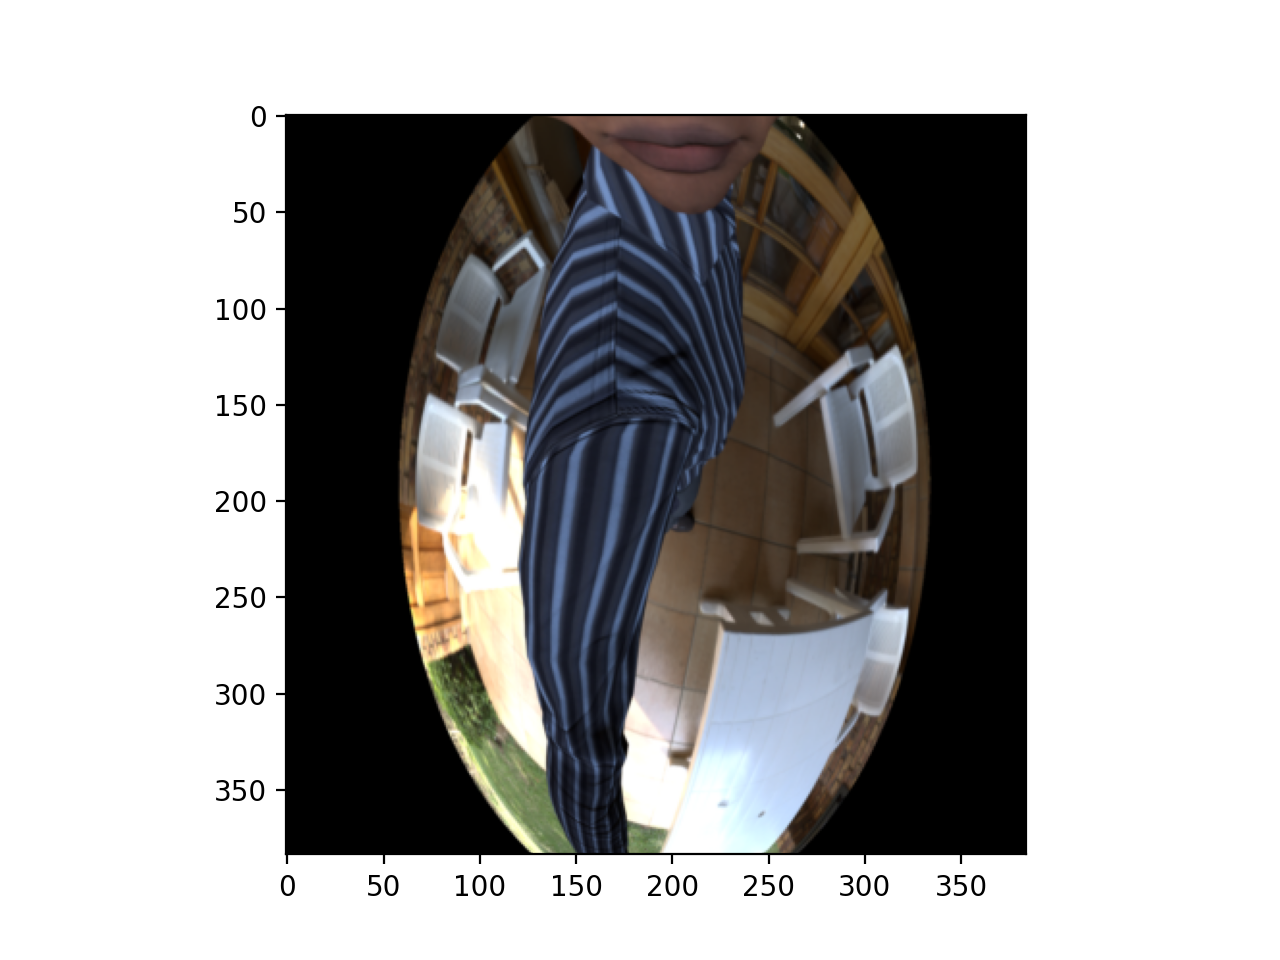

<IPython.core.display.Javascript object>


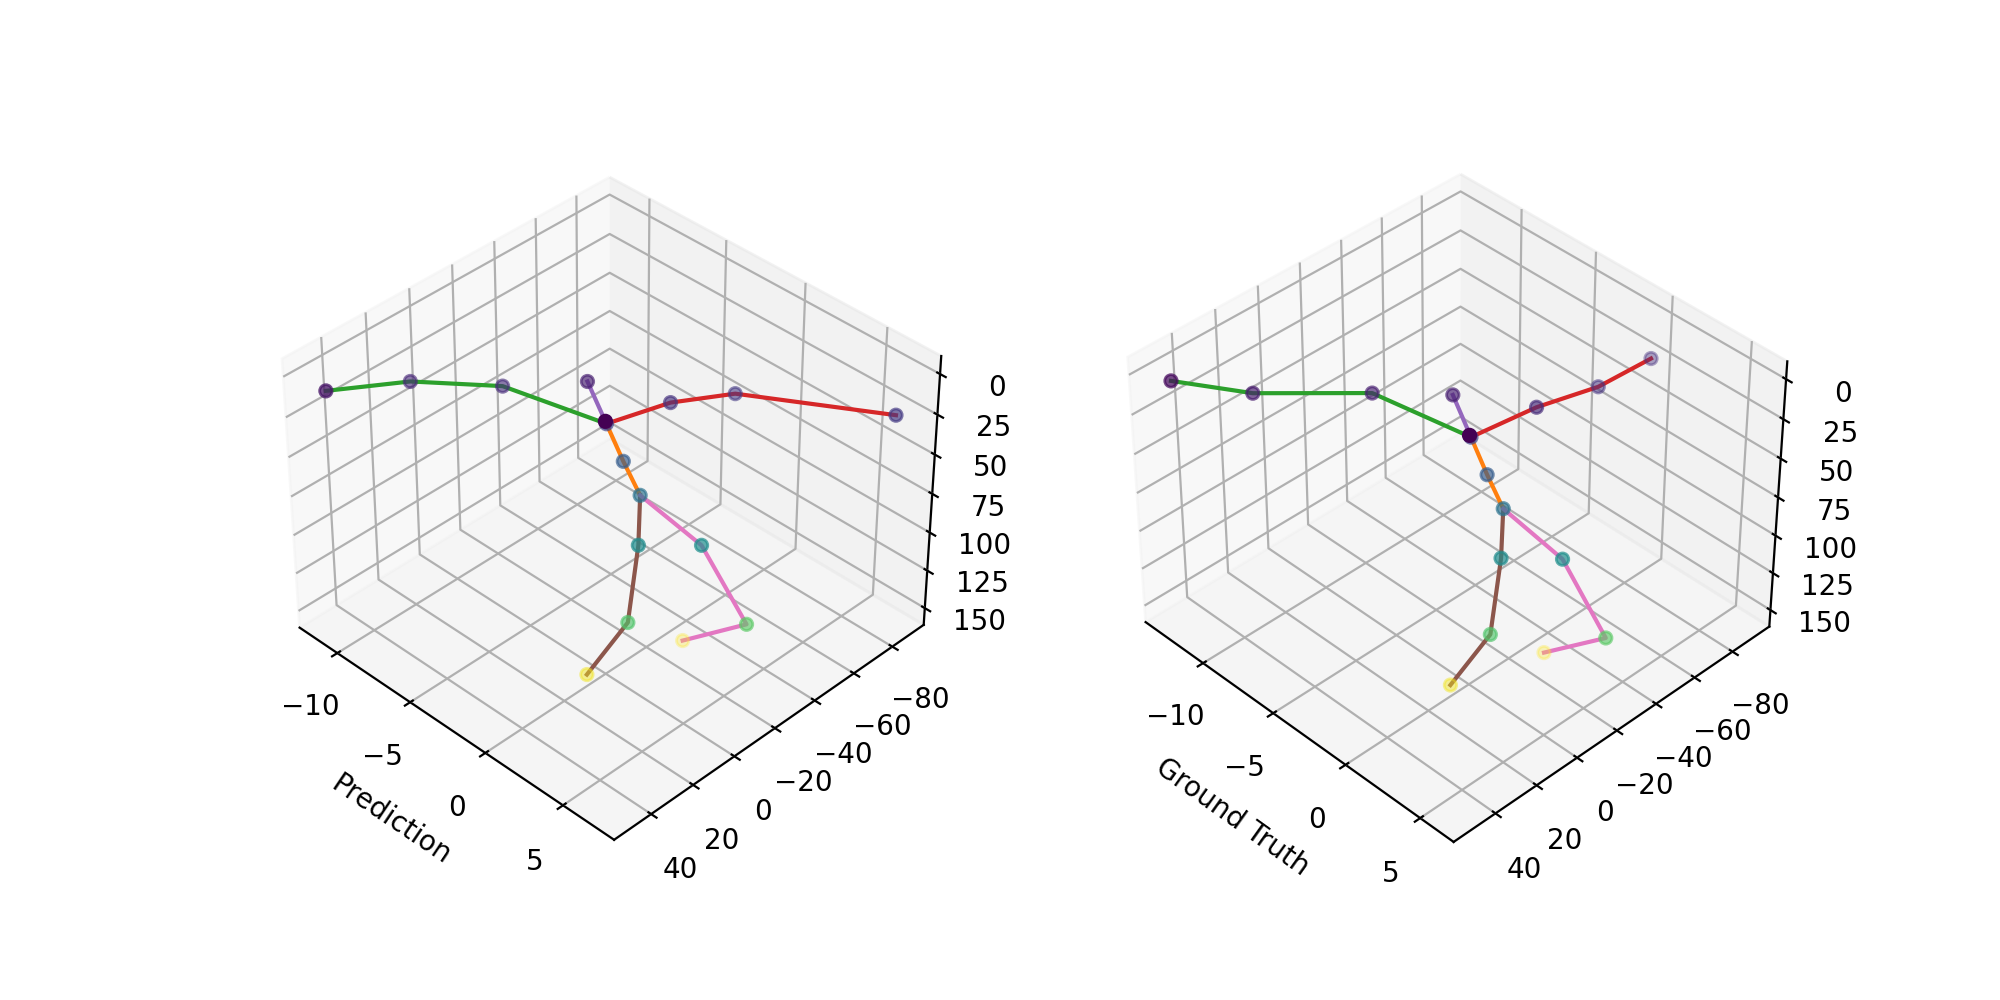

17
17


In [40]:
index = 789
plt.imshow(np.transpose(worst_imgs[index], (1,2,0)))
plt.show()
# var_worst = np.mean(var_worst, -1)
# var = np.ones((var_worst.shape[0], 17)) * 20
# var[:, 4:10] = var_worst*15

# errs = np.ones((var_worst.shape[0], 17)) * 7
# errs[:, 4:10] = worst_err * 3.5
# print(best_err[0])
# print(worst_err[-1])
pred = worst_gt[index].copy()
pred[4:10] = worst_10[0][index]

plot(worst_gt[index], pred,)

In [ ]:
mean_bestx = np.argsort(mean_best[:, 0])
mean_besty = np.argsort(mean_best[:, 1])
mean_bestz = np.argsort(mean_best[:, 2])

In [ ]:
mean_worstx = np.argsort(mean_worst[:, 0])
mean_worsty = np.argsort(mean_worst[:, 1])
mean_worstz = np.argsort(mean_worst[:, 2])



In [ ]:
plt.figure()
ax = plt.gca()
ax.set_ylim([-100, 100])

plt.title(f'VAE mean and var of high error predictions')
plt.plot(np.arange(total), mean_worst[mean_worstz,2], 'r-', label="mean z")
plt.fill_between(np.arange(total), mean_worst[mean_worstz,2] - var_worst[mean_worstz, 2], mean_worst[mean_worstz,2] + var_worst[mean_worstz, 2], color="pink")
plt.plot(np.arange(total), mean_worst[mean_worsty,1], 'g-', label="mean y")
plt.fill_between(np.arange(total), mean_worst[mean_worsty,1] - var_worst[mean_worsty, 1], mean_worst[mean_worsty,1] + var_worst[mean_worsty, 1], color="lightgreen")
plt.plot(np.arange(total), mean_worst[mean_worstx,0], 'b-', label="mean x")
plt.fill_between(np.arange(total), mean_worst[mean_worstx,0] - var_worst[mean_worstx, 0], mean_worst[mean_worstx,0] + var_worst[mean_worstx, 0], color="lightblue")
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.figure()
ax = plt.gca()
plt.title("VAE mean and var of low error predictions")
ax.set_ylim([-100, 100])
plt.plot(np.arange(total), mean_best[mean_bestz,2], "r-",  label="mean z")
plt.fill_between(np.arange(total), mean_best[mean_bestz,2] - var_best[mean_bestz, 2], mean_best[mean_bestz,2] + var_best[mean_bestz, 2], color="pink", alpha=0.9)

plt.plot(np.arange(total), mean_best[mean_besty,1], 'g-', label="mean y")
plt.fill_between(np.arange(total), mean_best[mean_besty,1] - var_best[mean_besty, 1], mean_best[mean_besty,1] + var_best[mean_besty, 1], color="lightgreen", alpha=0.9)

plt.plot(np.arange(total), mean_best[mean_bestx,0], 'b-', label="mean x")
plt.fill_between(np.arange(total), mean_best[mean_bestx,0] - var_best[mean_bestx, 0], mean_best[mean_bestx,0] + var_best[mean_bestx, 0], alpha=1, color="lightblue")
plt.legend(loc="upper left")
plt.show()